## Window size 1

In [1]:
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
nltk.download('punkt')

# Function to read and preprocess text
def read_and_preprocess(files):
    corpus = []
    for file in files:
        with open(file, 'r') as f:
            text = f.read().lower()
            # Remove punctuation
            text = re.sub(r'[^\w\s]', '', text)
            # Tokenize
            tokens = word_tokenize(text)
            corpus.extend(tokens)
    return corpus

# Specify the files for the seven books
files = ['harry_potter(1)/HP1.txt', 'harry_potter(1)/HP2.txt', 'harry_potter(1)/HP3.txt', 'harry_potter(1)/HP4.txt', 'harry_potter(1)/HP5.txt', 'harry_potter(1)/HP6.txt', 'harry_potter(1)/HP7.txt']

# Preprocess the text
corpus = read_and_preprocess(files)


[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [2]:
# Create vocabulary and mappings
unique_words = list(set(corpus))
word_to_idx = {word: i for i, word in enumerate(unique_words)}
idx_to_word = {i: word for i, word in enumerate(unique_words)}

# Label encoding for corpus
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(corpus)

# One-hot encoding for integer encoded corpus
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [3]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 1
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [4]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")

/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 542s 13ms/step - accuracy: 0.0912 - loss: 6.5294 - val_accuracy: 0.1088 - val_loss: 6.1464
Epoch 2/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 535s 13ms/step - accuracy: 0.1135 - loss: 6.0290 - val_accuracy: 0.1107 - val_loss: 6.1143
Epoch 3/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 521s 13ms/step - accuracy: 0.1160 - loss: 5.9058 - val_accuracy: 0.1101 - val_loss: 6.1042
Epoch 4/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 526s 13ms/step - accuracy: 0.1175 - loss: 5.8186 - val_accuracy: 0.1079 - val_loss: 6.1358
Epoch 5/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 502s 12ms/step - accuracy: 0.1183 - loss: 5.7635 - val_accuracy: 0.1095 - val_loss: 6.1815
Epoch 6/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 500s 12ms/step - accuracy: 0.1187 - loss: 5.7180 - val_accuracy: 0.1087 - val_loss: 6.2254
Epoch 7/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 503s 12ms/step - accuracy: 0.1186 - loss: 5.6946 - val_accuracy: 0.1085 - val_loss: 6.2901
Epoch 8/20
40910/40910 ━━━━━━━━━━━━━━━━━━━━ 509s 12ms/s

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
he: 0.6744
hermione: 0.6542
ron: 0.6531
she: 0.6051
neville: 0.5889
snape: 0.5783
lupin: 0.5774
fred: 0.5603
dumbledore: 0.5367
ginny: 0.5335


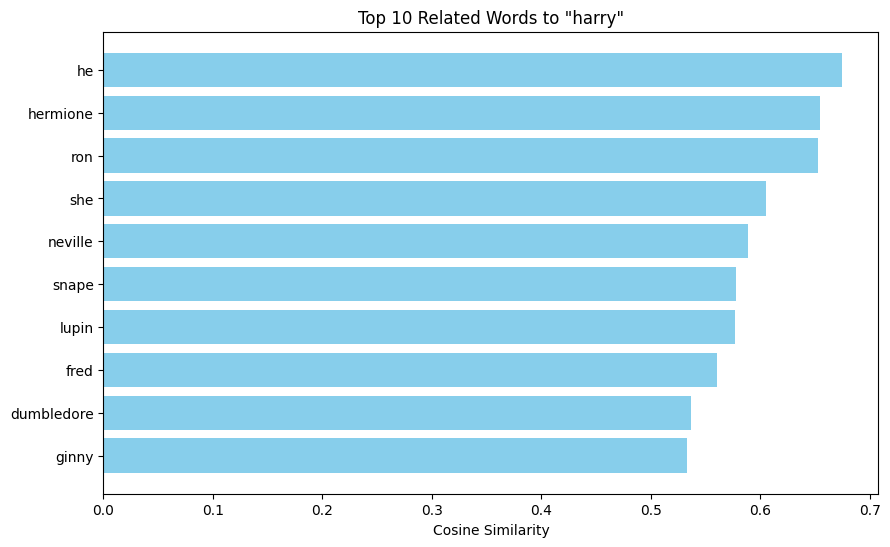

In [6]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


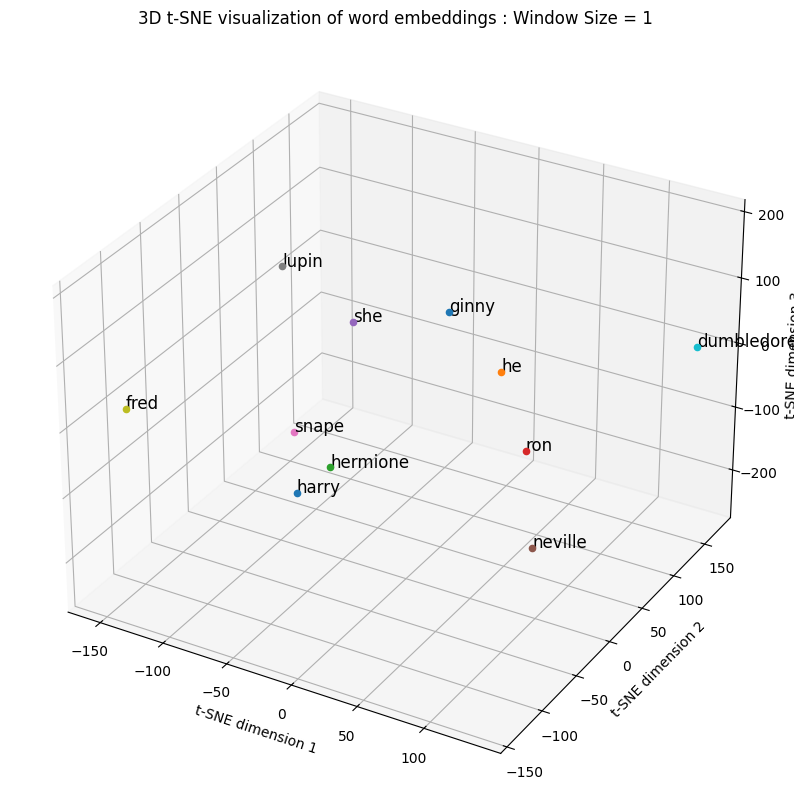

In [7]:
from sklearn.manifold import TSNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings : Window Size = 1')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

## Increase window size - 3

In [14]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 3
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [15]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")

/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1760s 14ms/step - accuracy: 0.0558 - loss: 6.7967 - val_accuracy: 0.0594 - val_loss: 6.7082
Epoch 2/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1820s 15ms/step - accuracy: 0.0605 - loss: 6.6601 - val_accuracy: 0.0594 - val_loss: 6.7388
Epoch 3/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1811s 15ms/step - accuracy: 0.0613 - loss: 6.6287 - val_accuracy: 0.0590 - val_loss: 6.7973
Epoch 4/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1819s 15ms/step - accuracy: 0.0617 - loss: 6.6189 - val_accuracy: 0.0589 - val_loss: 6.8016
Epoch 5/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1823s 15ms/step - accuracy: 0.0621 - loss: 6.5867 - val_accuracy: 0.0587 - val_loss: 6.8016
Epoch 6/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1846s 15ms/step - accuracy: 0.0621 - loss: 6.5711 - val_accuracy: 0.0582 - val_loss: 6.8001
Epoch 7/20
122729/122729 ━━━━━━━━━━━━━━━━━━━━ 1831s 15ms/step - accuracy: 0.0623 - loss: 6.5586 - val_accuracy: 0.0585 - val_loss: 6.7939
Epoch 8/20
122729/122729 ━━━━━━━━━

KeyboardInterrupt: 

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=20):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=20)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
jesting: 0.4988
doctors: 0.4717
mulishly: 0.4688
ron: 0.4663
ginny: 0.4598
hagrid: 0.4449
he: 0.4440
reprovingly: 0.4434
elped: 0.4391
fred: 0.4329
hermione: 0.4324
cajolingly: 0.4304
unhappily: 0.4248
gim: 0.4242
george: 0.4232
sharpener: 0.4159
midwinter: 0.4129
moody: 0.4088
scabbersl: 0.4073
pansys: 0.4058


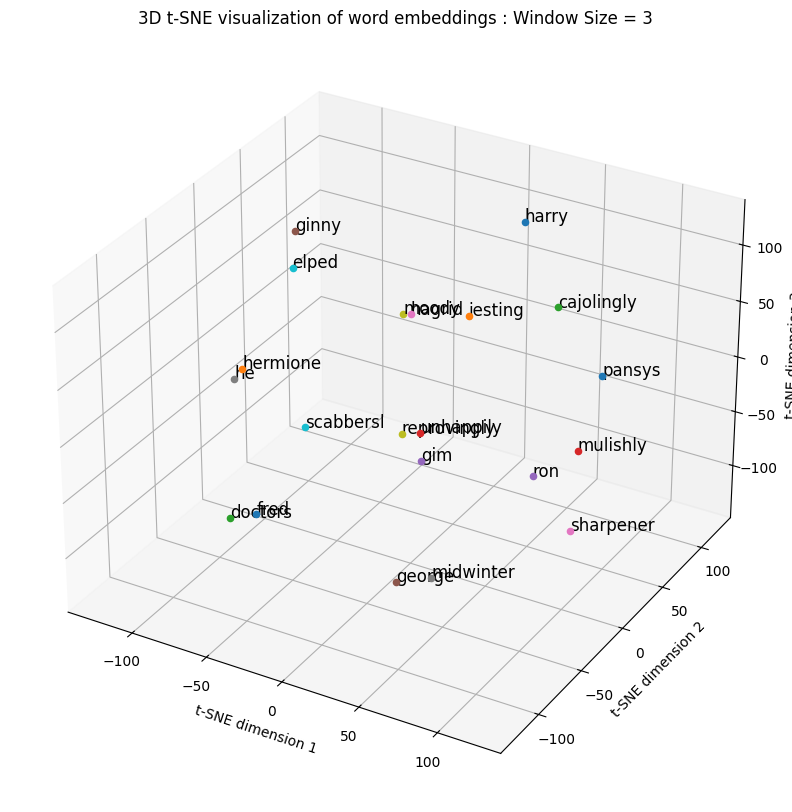

In [17]:
# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings : Window Size = 3')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

# Increase window size - 5

In [8]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 5
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [9]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")

/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2623s 13ms/step - accuracy: 0.0496 - loss: 6.8446 - val_accuracy: 0.0503 - val_loss: 6.8441
Epoch 2/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2602s 13ms/step - accuracy: 0.0512 - loss: 6.8168 - val_accuracy: 0.0506 - val_loss: 6.8796
Epoch 3/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2588s 13ms/step - accuracy: 0.0517 - loss: 6.8116 - val_accuracy: 0.0508 - val_loss: 6.8729
Epoch 4/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2620s 13ms/step - accuracy: 0.0518 - loss: 6.7937 - val_accuracy: 0.0505 - val_loss: 6.8705
Epoch 5/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2603s 13ms/step - accuracy: 0.0521 - loss: 6.7802 - val_accuracy: 0.0507 - val_loss: 6.8777
Epoch 6/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2594s 13ms/step - accuracy: 0.0522 - loss: 6.7655 - val_accuracy: 0.0498 - val_loss: 6.8866
Epoch 7/20
204548/204548 ━━━━━━━━━━━━━━━━━━━━ 2597s 13ms/step - accuracy: 0.0523 - loss: 6.7538 - val_accuracy: 0.0501 - val_loss: 6.8840
Epoch 8/20
204548/204548 ━━━━━━━━━

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=20):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=20)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
ron: 0.5170
voldemorti: 0.4546
parvati: 0.4376
whaddid: 0.4356
scabbers: 0.4340
sounding: 0.4307
bugged: 0.4271
sirius: 0.4250
lupin: 0.4206
sceptically: 0.4159
vicky: 0.4157
he: 0.4154
helplessly: 0.4133
penny: 0.4107
tentatively: 0.4060
showoffs: 0.4009
shocked: 0.3991
grinning: 0.3970
quietly: 0.3946
sneer: 0.3938


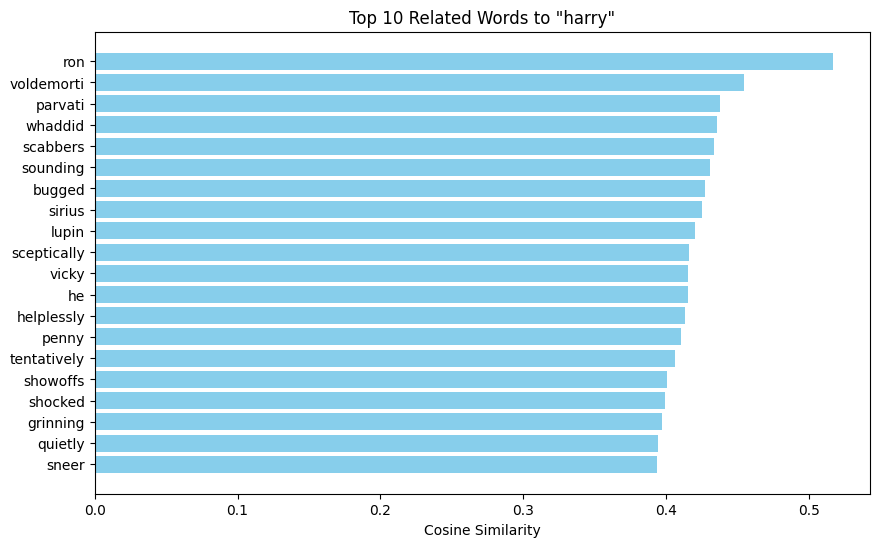

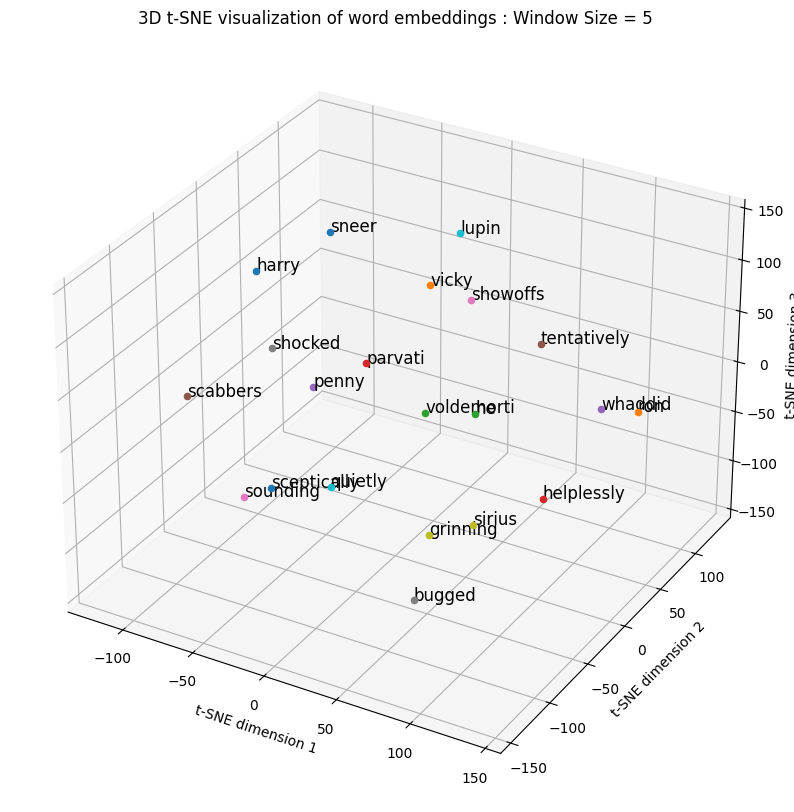

In [11]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()

# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings : Window Size = 5')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()